# PG-SCOTT result exploration

Scores generated in `find_genes_peaks.ipynb`. This notebook will serve to examine interesting peak-gene pairs based on the generated scores, and determine whether conclusions about statistical significance can be drawn from a bootstrapped approach.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
# load data
sensitivity_df = pd.read_csv('./data/pg_pairs_sensitivity.csv', index_col=[0, 1], header=[0, 1])
specificity_df = pd.read_csv('./data/pg_pairs_specificity.csv', index_col=[0, 1], header=[0, 1])
universality_df = pd.read_csv('./data/pg_pairs_universality.csv', index_col=[0, 1])
rna_adata = ad.read_h5ad('./data/rna.h5ad')
atac_adata = ad.read_h5ad('./data/atac.h5ad')

### View Distributions

Start by looking at the distributions associated with different scores, and how they relate to the input data (average RNA and ATAC across replicates)

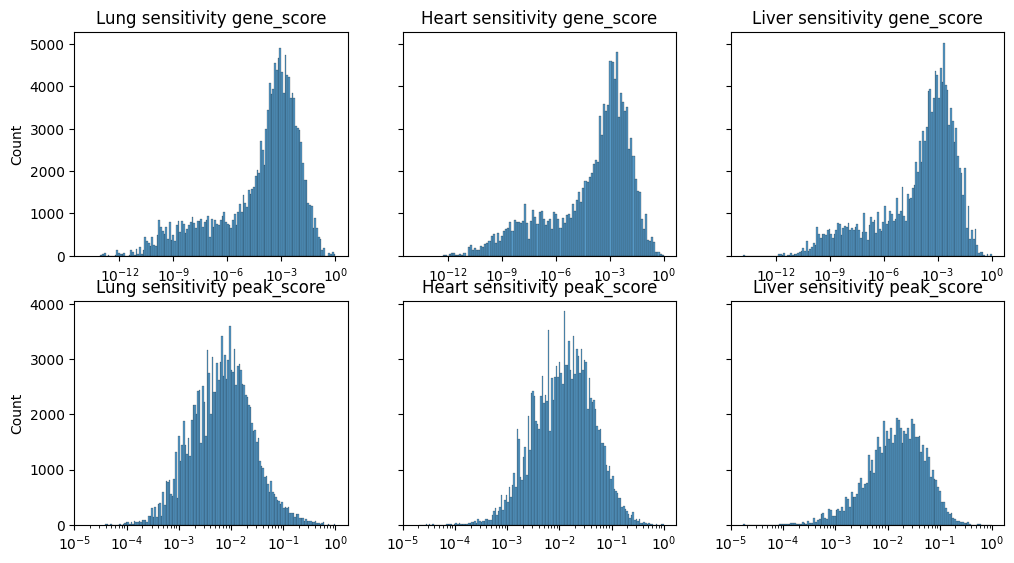

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6.4), sharey='row', sharex='row')
for (col, ax) in zip(sensitivity_df.columns, axs.flatten(order='F')):
  sns.histplot(sensitivity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} sensitivity {col[1]}')

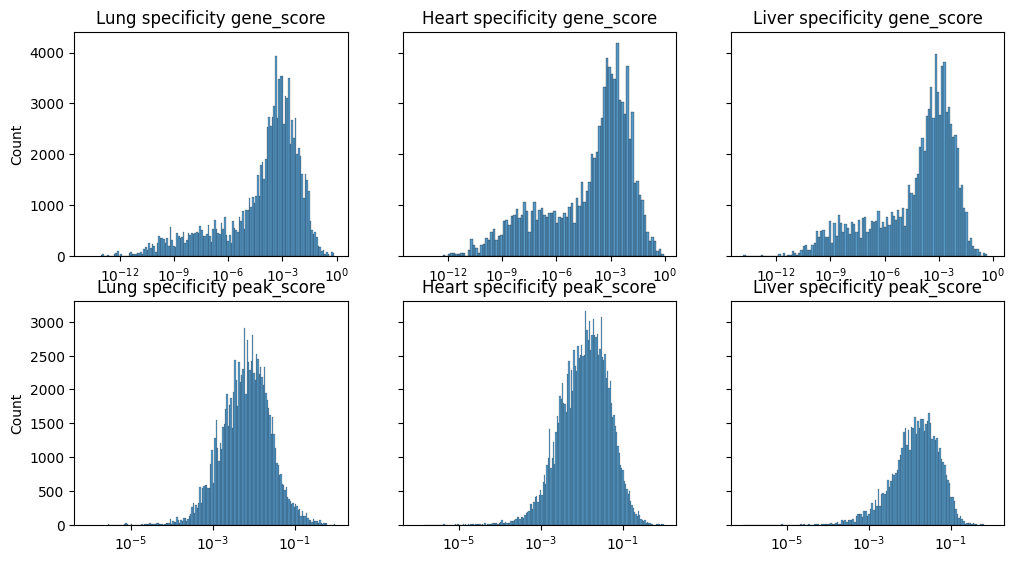

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6.4), sharey='row', sharex='row')
for (col, ax) in zip(specificity_df.columns, axs.flatten(order='F')):
  sns.histplot(specificity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} specificity {col[1]}')

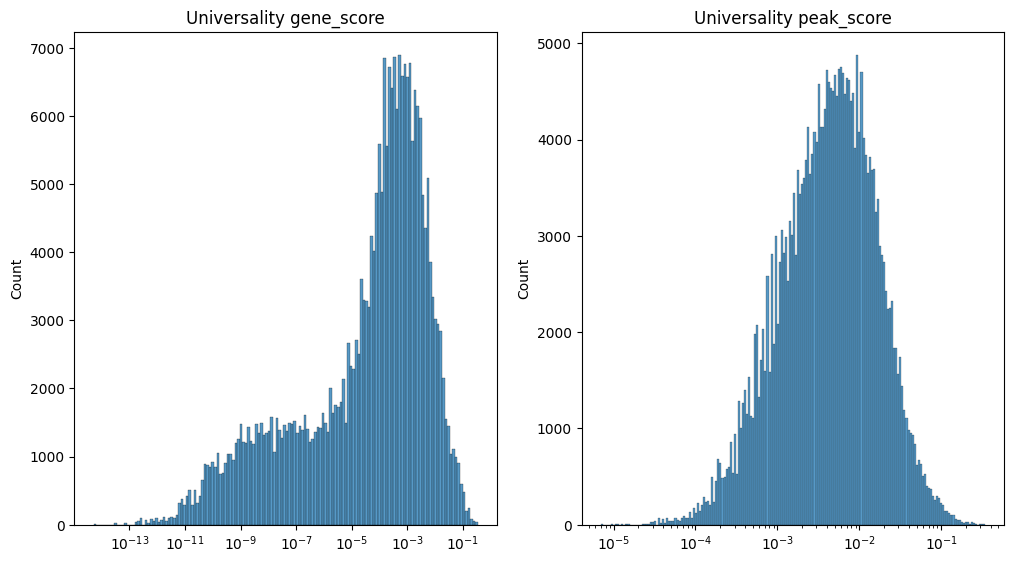

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6.4))
for (col, ax) in zip(universality_df.columns, axs.flatten(order='F')):
  sns.histplot(universality_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'Universality {col}')

In [6]:
def calc_condition_gene_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  condition_avg_df = organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates
  condition_avg_df['gene'] = organ_adata.var['gene']
  return condition_avg_df.groupby('gene', observed = False).aggregate('sum')  # Sum across gene variants

In [7]:
organs = ['Lung', 'Heart', 'Liver']
rna_df = pd.concat([calc_condition_gene_averages(rna_adata, organ) for organ in organs], axis=1, keys=organs)

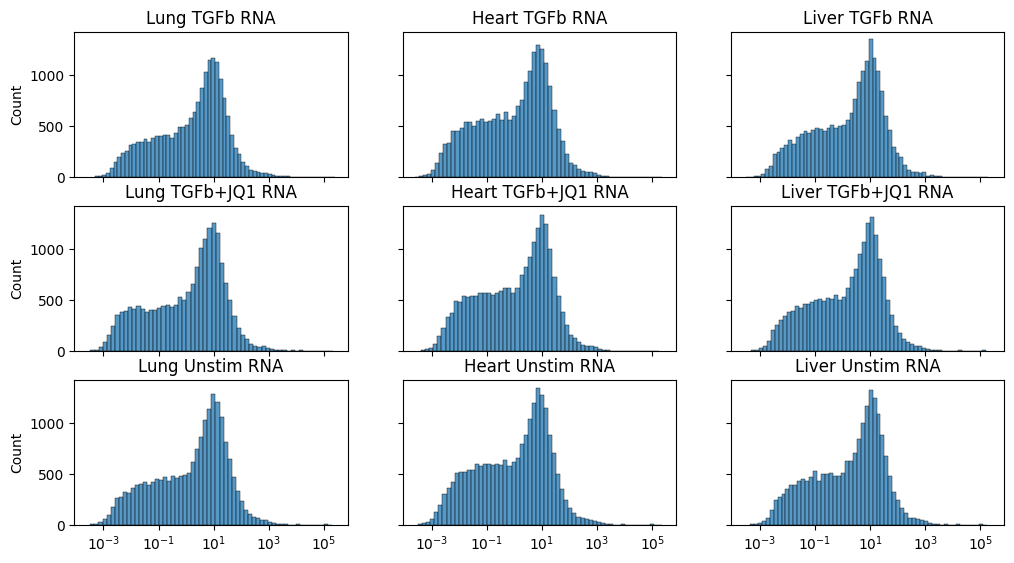

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(rna_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA')

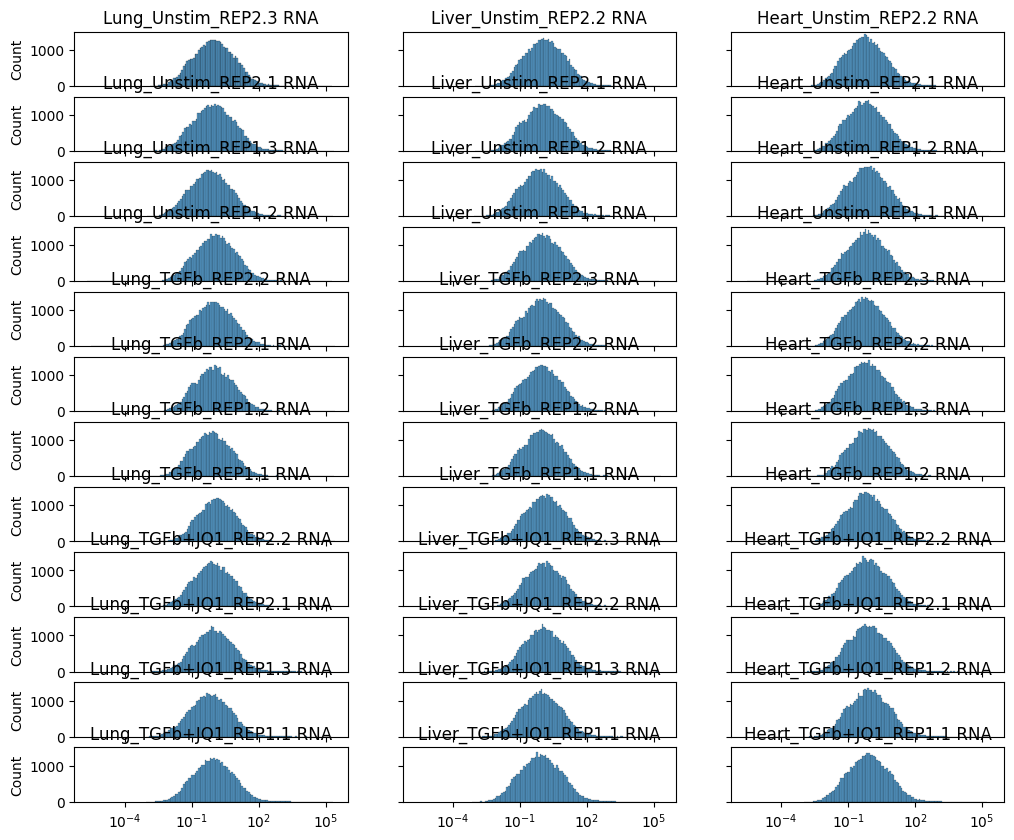

In [22]:
fig, axs = plt.subplots(12, 3, figsize=(12, 10), sharey='all', sharex='all')
for (col, ax) in zip(rna_adata.obs_names.sort_values(ascending=False), axs.flatten(order='F')):
  sns.histplot(rna_adata[col].X[0], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} RNA')

In [9]:
def calc_condition_peak_averages(adata: ad.AnnData, organ: str, layer: str = None) -> pd.DataFrame:
  organ_adata = adata[adata.obs['organ'] == organ, :]
  organ_df = organ_adata.to_df(layer = layer)
  organ_df['condition'] = organ_adata.obs['condition']
  return organ_df.groupby('condition', observed = False).aggregate('mean').T  # Average across replicates

In [10]:
atac_df = pd.concat([calc_condition_peak_averages(atac_adata, organ) for organ in organs], axis=1, keys=organs)

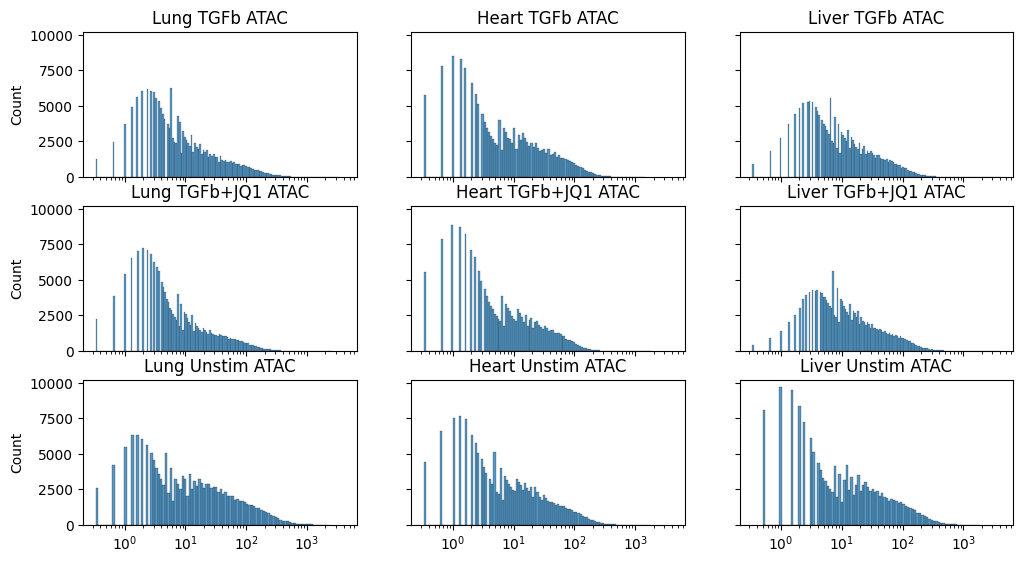

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(atac_df.columns, axs.flatten(order='F')):
  sns.histplot(atac_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} ATAC')

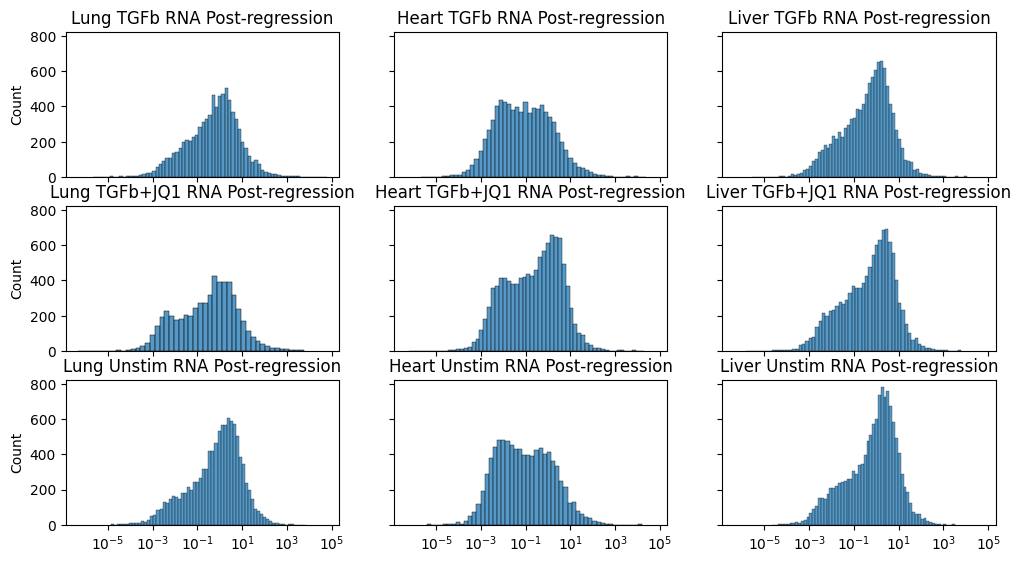

In [12]:
rna_postreg_df = pd.concat([calc_condition_gene_averages(rna_adata, organ, layer = 'post-regression') for organ in organs], axis=1, keys=organs)
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(rna_postreg_df.columns, axs.flatten(order='F')):
  sns.histplot(rna_postreg_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA Post-regression')

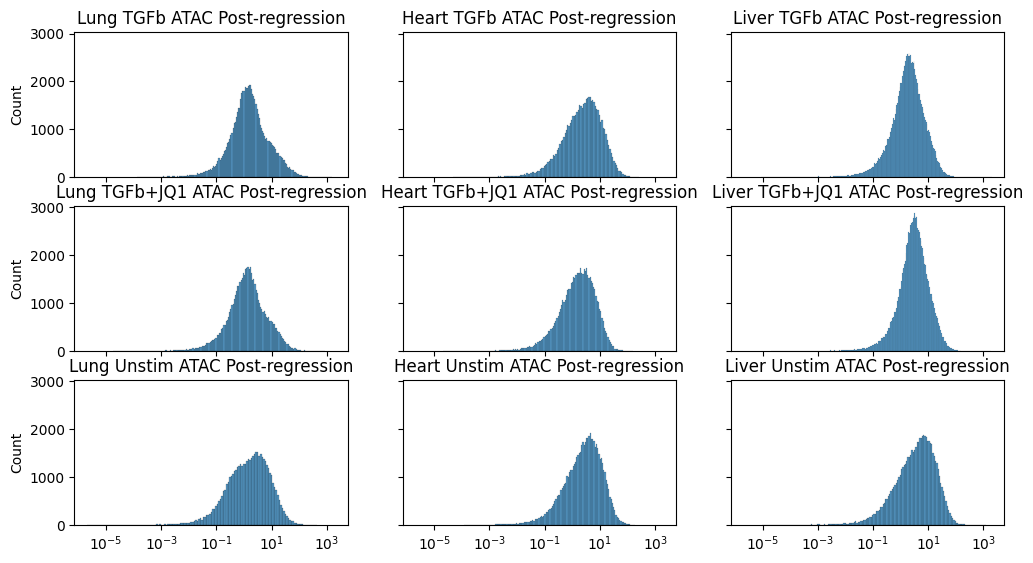

In [13]:
atac_postreg_df = pd.concat([calc_condition_peak_averages(atac_adata, organ, layer = 'post-regression') for organ in organs], axis=1, keys=organs)
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(atac_postreg_df.columns, axs.flatten(order='F')):
  sns.histplot(atac_postreg_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} ATAC Post-regression')

### Determine Replicability with Null Data
Create null data by randomly sampling from original data to determine if distributions would look different by random chance

In [14]:
rand = np.random.default_rng(seed=0)
random_rna_df = pd.DataFrame(rand.choice(rna_df.values.flatten(), size=rna_df.shape), columns = rna_df.columns)
random_atac_df = pd.DataFrame(rand.choice(atac_df.values.flatten(), size=atac_df.shape), columns = atac_df.columns)

In [15]:
def calc_condition_sensitivity(organ_df: pd.DataFrame) -> pd.DataFrame:
  """Uses log fold change to determine which genes are up- and down-regulated in each condition"""
  odf_copy = organ_df + 1
  lfc_df = pd.DataFrame({
    'up': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb'] / odf_copy['Unstim']),
    'down': np.sqrt(np.log2(odf_copy.mean(axis = 1))) * np.log2(odf_copy['TGFb+JQ1'] / odf_copy['TGFb']),
  })
  t = np.sign(np.sign(odf_copy['Unstim'] - odf_copy['TGFb']) - np.sign(odf_copy['TGFb'] - odf_copy['TGFb+JQ1']))
  lfc_df['score'] = lfc_df['up'] * lfc_df['down'] * t
  return lfc_df

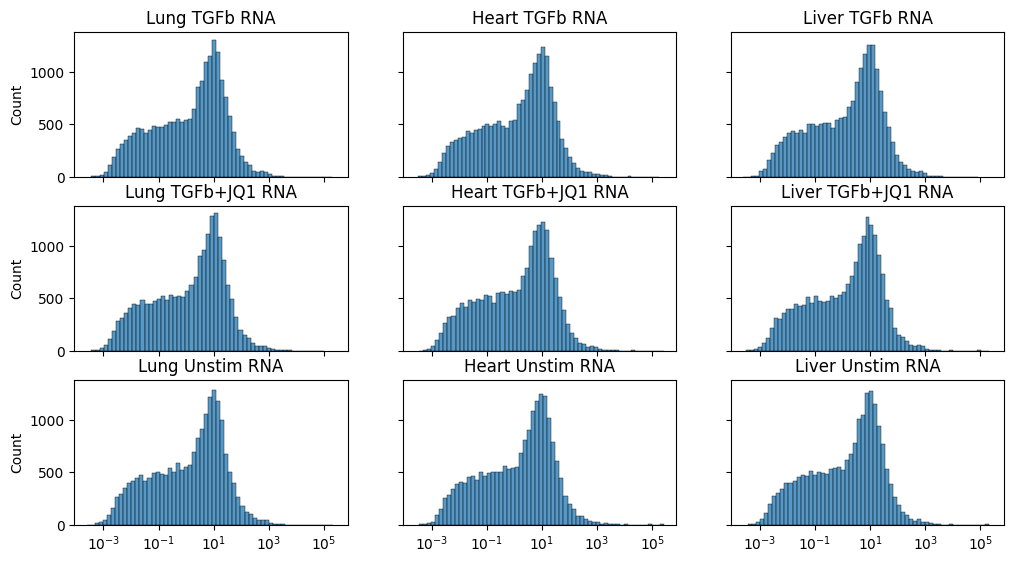

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6.4), sharey='all', sharex='all')
for (col, ax) in zip(random_rna_df.columns, axs.flatten(order='F')):
  sns.histplot(random_rna_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col[0]} {col[1]} RNA')

In [ ]:
random_rna_sensitivity_df = pd.concat([calc_condition_sensitivity(random_rna_df[organ])['score'] for organ in organs], axis=1, keys=organs)

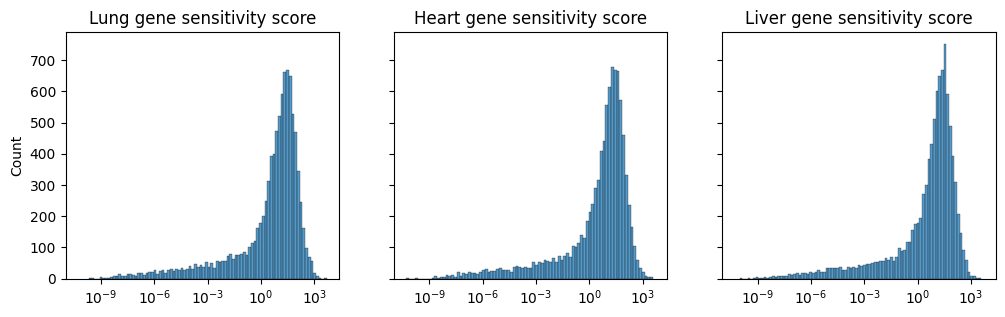

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.2), sharey='all', sharex='all')
for (col, ax) in zip(random_rna_sensitivity_df.columns, axs.flatten(order='F')):
  sns.histplot(random_rna_sensitivity_df[col], log_scale=(True, False), ax=ax)
  ax.set_xlabel('')
  ax.set_title(f'{col} gene sensitivity score')